<a href="https://colab.research.google.com/github/onstriqui/Adaptive-Video-Bitrate-Allocation-4-RODV/blob/main/Object_Loss_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This notebook contains the steps followed in order to create a dataset. The latter is obtained later on and is used to train a model that takes the detected object (its class, its coordinates and its distance from the ego vehicle) as an input, and predicts the loss that would be caused by the compression.**

# _The main idea was to evaluate how much compression affects the perception of the surroundings for each camera. For that, we used an annotated dataset from the mini version of nuscenes, compressed the dataset at 5 different compression rates and ran a pre-trained detection model (YOLOv5) after the compression to see if the objects were detected. Later on, we calculated the pourcentage of times the object wasn't detected. That is considered as the loss introduced by the object._

In [ ]:
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib

In [ ]:
from google.colab import files

In [ ]:
#  Import torch and other libraries
import torch
import torchvision
import torchaudio
import cv2
import matplotlib.pyplot as plt
import pandas as pd

**YOLOv5 is a 2-dimensions detection model, meaning it only uses camera data (no radars or lidar) in order to detect an object. So, it's the most suitable to evaluate the perception of an image after compression.**

In [ ]:
# Step 1: Load YOLOv5 Pre-trained Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # Pre-trained on COCO dataset

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-8-29 Python-3.10.12 torch-2.4.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


**This step is important because the annotations from nuscenes and from YOLOv5 aren't exacly the same, so we filtered some classes in both sets.**

In [ ]:
# Step 2: Define the classes you want to ignore (from yolov5)
# COCO class IDs: https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
ignore_classes = ['traffic light', 'stop sign', 'traffic cone', 'bench']

In [ ]:
# Function to filter detections
def filter_detections(results, ignore_classes):
    # Get the names of all COCO classes
    class_names = model.names

    # Iterate through each detected object
    filtered_detections = []
    for i, det in enumerate(results.xyxy[0]):  # xyxy format for bbox
        class_id = int(det[5])  # Class ID is the 6th element in results
        class_name = class_names[class_id]

        # Check if this class is not in the ignore list
        if class_name not in ignore_classes:
            filtered_detections.append(det)  # Keep this detection

    return filtered_detections

**Upload an image and detect objects (for testing):**



In [ ]:
# Function to Display the results

def plot_detections(image, detections):
    for det in detections:
        # Extract bounding box coordinates
        x1, y1, x2, y2 = int(det[0]), int(det[1]), int(det[2]), int(det[3])
        class_id = int(det[5])
        class_name = model.names[class_id]

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    # Show the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


Saving n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657121112404.jpg to n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657121112404 (1).jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


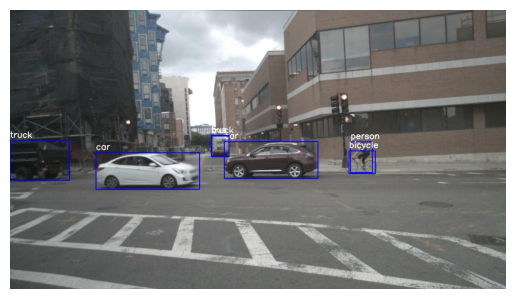

In [ ]:
%matplotlib inline
uploaded = files.upload()
image = list(uploaded.keys())[0] #choose only one image
img = cv2.imread(image)

# Perform object detection
results = model(img)

filtered_detections = filter_detections(results, ignore_classes)
# Plot the filtered detections
plot_detections(img, filtered_detections)

In [ ]:
# Step 3: Load images
#We manually loaded the images locally, but it is possible to mount the drive and use the zipped folder (approach more described in the compression notebook)
uploaded = files.upload()
image_names = list(uploaded.keys())


**Even though we're using the annotations of nuscenes as the ground truth objects, we can't be sure that YOLOv5 would be able to detect every object even before the compression, so the loss calculated after the compression might be tampered with.
To go around that, we ran the pre-trained YOLOv5 model on the images before the compression, made a list of every detected object, then we looped through the annotations of nuscenes and only kept the objects that were in common.**

In [ ]:
# Function to run detection (2D) and save results
def detect_objects_and_save(images_names, csv_output):
    # Create a list to store results
    results_list = []

    # Iterate through all images in the dataset folder
    for image in images_names:
          img = cv2.imread(image)

          # Perform object detection
          results = model(img)

          # Filter detections and ignore unwanted objects
          for det in results.xyxy[0].cpu().numpy():
              x1, y1, x2, y2, conf, class_id = det
              class_name = model.names[int(class_id)]

              # Ignore unwanted classes
              if class_name in ignore_classes:
                  continue

              # Save the result (filename, coordinates, and label)
              result = {
                  'filename': image,
                  'coordinates': [int(x1), int(y1), int(x2), int(y2)],
                  'label': class_name,
                  'accepted': False,
                  'distance' : 0,
                  'detected_R1' :False,
                  'detected_R2' : False,
                  'detected_R3': False,
                  'detected_R4': False,
                  'detected_R5': False

              }
              results_list.append(result)
    df = pd.DataFrame(results_list, columns=['filename', 'coordinates', 'label','accepted','distance','detected_R1','detected_R2','detected_R3','detected_R4','detected_R5'])


    df.to_csv(csv_output, index=False)
    print(f'Results saved to {csv_output}')

In [ ]:
detect_objects_and_save(image_names, 'detection_resluts.csv')

Results saved to detection_resluts.csv


In [ ]:
#%matplotlib inline

**To be able to associate two detected objects, we need to compute their intersection over union (iou):**

In [ ]:
def compute_iou(boxA, boxB):
    # Determine the (x, y) coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

**In the next few cells, we're finally using the nuScenes annotations**

In [ ]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2024-08-27 10:31:12--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 13.227.219.45, 13.227.219.6, 13.227.219.76, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|13.227.219.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   100MB/s    in 50s     

2024-08-27 10:32:02 (79.8 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



**We need to convert the categories for compatibility reasons. The unwanted classes won't be converted and will just be ignored later (if they don't exist the the 'categories' list).**

In [ ]:
def convert_category(category):
    category_map = {
        "human.pedestrian.adult": "person",
        "human.pedestrian.child": "person",
        "human.pedestrian.wheelchair": "person",
        "human.pedestrian.stroller": "person",
        "human.pedestrian.personal_mobility": "person",
        "human.pedestrian.police_officer": "person",
        "human.pedestrian.construction_worker": "person",
        "vehicle.car": "car",
        "vehicle.emergency.police": "car",
        "vehicle.bicycle": "bicycle",
        "vehicle.bus.bendy": "bus",
        "vehicle.bus.rigid": "bus",
        "vehicle.motorcycle": "motorcycle",
        "vehicle.truck": "truck",
        "vehicle.construction": "truck",
        "vehicle.emergency.ambulance": "truck",
        "vehicle.trailer": "truck"
    }

    return category_map.get(category, category)

categories=['person','car','truck','motorcycle','bus','bicycle']

**In order to compute the iou between the nuScenes annotations and the initial detections, the 3D bounding boxes of nuscenes need to be projected into 2D format.**

In [ ]:

from pyquaternion import Quaternion
import numpy as np
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import Box

# Helper function to convert 3D bounding box to 2D and calculate distance between the ego vehicle and the detected object
def project_3d_bbox_to_2d(nusc, sample_annotation_token, camera_data):
    ann_record = nusc.get('sample_annotation', sample_annotation_token)
    sample_data_record = nusc.get('sample_data', camera_data['token'])

    # Load calibrated sensor and ego pose
    cs_record = nusc.get('calibrated_sensor', sample_data_record['calibrated_sensor_token'])
    ego_pose = nusc.get('ego_pose', sample_data_record['ego_pose_token'])

    # Ensure that rotation is converted to a Quaternion object
    rotation = ann_record['rotation']
    if not isinstance(rotation, Quaternion):
        rotation = Quaternion(rotation)

    # Create a Box instance with the correct quaternion format
    box = Box(ann_record['translation'], ann_record['size'], rotation)

    # Transform box to ego vehicle frame
    box.translate(-np.array(ego_pose['translation']))
    box.rotate(Quaternion(ego_pose['rotation']).inverse)

    # Transform box to camera frame
    box.translate(-np.array(cs_record['translation']))
    box.rotate(Quaternion(cs_record['rotation']).inverse)

    # Project the 3D bounding box to 2D
    cam_intrinsic = np.array(cs_record['camera_intrinsic'])
    corners_2d = view_points(box.corners(), cam_intrinsic, normalize=True)[:2, :]

    # Calculate the 2D bounding box
    x_min = np.clip(np.min(corners_2d[0, :]), 0, camera_data['width'])
    x_max = np.clip(np.max(corners_2d[0, :]), 0, camera_data['width'])
    y_min = np.clip(np.min(corners_2d[1, :]), 0, camera_data['height'])
    y_max = np.clip(np.max(corners_2d[1, :]), 0, camera_data['height'])

    # Check for any invalid (infinite or NaN) coordinates
    if not np.isfinite([x_min, x_max, y_min, y_max]).all() or (x_min == x_max or y_min == y_max):
        print(f"Invalid bounding box detected for sample_annotation_token: {sample_annotation_token}")
        return None, None, None

    # Get the translation of the object in the camera frame
    object_translation = box.center  # This is the 3D position of the object in the camera frame

    # The actual distance is the norm (Euclidean distance) of the object translation vector in the camera frame
    distance = np.linalg.norm(object_translation)

    # Return the 2D bounding box, category name, and actual distance
    return [int(x_min), int(y_min), int(x_max), int(y_max)], ann_record['category_name'], distance

In [ ]:
from google.colab import files
import pandas as pd
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import view_points
import numpy as np
import cv2

In [ ]:
# Mount your NuScenes dataset
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.096 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [ ]:
# Upload and load the CSV file that was created earlier (this step could be ignored if the csv file is already loaded)
uploaded = files.upload()
csv_filename = list(uploaded.keys())[0]
df = pd.read_csv(csv_filename)

Saving detection_resluts (2).csv to detection_resluts (2).csv


**Compare the detected objects initially with the ground truth:**  If an object is found, 'accepted' becomes True and the distance is updated.

In [ ]:
import ast
# Loop through each sample

for sample in nusc.sample:
  camera_token = sample['data']['CAM_FRONT']
  camera_data = nusc.get('sample_data', camera_token)

  image_path = nusc.get_sample_data_path(camera_token)

    # Read the image using OpenCV
  img = cv2.imread(image_path)

  # Check if the image was successfully loaded
  if img is not None:
      # Get the dimensions of the image (height, width, and channels)
      height, width, channels = img.shape

      # Print the image size (height and width)
      print(f'Image size for {image_path}: {width}x{height}')
  else:
      print(f"Failed to load image for {image_path}")

  # Loop through each annotation in the sample
  for ann_token in sample['anns']:

    bbox_2d_gt, category_name_gt, distance = project_3d_bbox_to_2d(nusc, ann_token, camera_data)
    category_name_gt=convert_category(category_name_gt)
    if category_name_gt not in categories:
      continue
    if bbox_2d_gt is None:
      continue  # Skip this annotation if invalid


    # Get the filename of the front camera image
    image_filename = nusc.get('sample_data', camera_token)['filename']
    image_filename = image_filename.replace('samples/CAM_FRONT/', '')


    # Filter CSV by filename
    filtered_df = df[df['filename'] == image_filename]

    filtered_df['coordinates'] = filtered_df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



    # Compare each detected object with ground truth
    for index, row in filtered_df.iterrows():
        #print('coordinates type:',type(row['coordinates']))
        #print(row['coordinates'][0])

        bbox_2d_det = [int(row['coordinates'][0]),int(row['coordinates'][1]),int( row['coordinates'][2]),int(row['coordinates'][3])]
        #print('detection:',bbox_2d_det)
        #print('ground truth',bbox_2d_gt)
        iou = compute_iou(bbox_2d_gt, bbox_2d_det)

        # Check IoU and matching category
        #print('iou:',iou, 'detected label: ',row['label'] ,'ground truth label:', category_name_gt)
        if iou > 0.5 and row['label'] == category_name_gt:
            # Update the CSV with acceptance and distance
            df.at[index, 'accepted'] = True
            df.at[index, 'distance'] = distance


# Save the updated CSV
df.to_csv('updated_detections.csv', index=False)

Check the "viability of object association" document to get a more tangible feel as to what the previous cell did.

**Delete the false predictions:** if a detected object didn't match with any annotation from nuscenes (meaning the iou is under the threshhold or the category name didn't match), we deleted it.

In [ ]:
uploaded = files.upload() #(this step could be ignored if the csv file is already loaded)
csv_filename = list(uploaded.keys())[0] #(this step could be ignored if the csv file is already loaded)
df2 = pd.read_csv(csv_filename)
df2 = df2[df2['accepted'] == True]
df2.to_csv('true_detections.csv', index=False)

Saving updated_detections (3).csv to updated_detections (3).csv


**Check if the detections after the compression are accurate (assume that the dataset of the compressed images exists in the drive, also check "compression" notebook for the compression process):**



This cell needs to be ran for each compression (with a few corresponding changes). The detected_Ri column is initialized to False. If the object is detected after the compression its value changes.



In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

R1_dir = '/content/drive/MyDrive/Fifth_Compression'


import ast
import os
import glob

#upload the file that has the filtered detections

#uploaded = files.upload()
#csv_filtered_detections = list(uploaded.keys())[0]
#filtered_df = pd.read_csv(csv_filtered_detections)

class_names = model.names

#add a loop to go through the folder that has the compressed images

image_paths = glob.glob(os.path.join(R5_dir, '*.jpg'))  # Adjust the extension if needed

for image_path in image_paths:

  # Read the image using OpenCV
  img = cv2.imread(image_path)
  results=model(img)
  filtered_detections = filter_detections(results, ignore_classes)


  # Loop through each annotation in the sample
  for detection in filtered_detections:

    # Get the filename of the front camera image
    image_filename = os.path.basename(image_path)
    image_filename = image_filename.replace('_Fifth_Compression', '')



    # Filter CSV by filename
    filename_df = filtered_df[filtered_df['filename'] == image_filename]

    filename_df['coordinates'] = filename_df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) #assert that the coordinates are of 'list' type



    # Compare each detected object after compression with the filtered ground truth detections
    for index, row in filename_df.iterrows():
        #print('coordinates type:',type(row['coordinates']))
        #print(row['coordinates'][0])

        bbox_2d_det = [int(row['coordinates'][0]),int(row['coordinates'][1]),int( row['coordinates'][2]),int(row['coordinates'][3])]
        #print('detection:',bbox_2d_det)

        iou = compute_iou(detection, bbox_2d_det)

        class_id = int(detection[5])  # Class ID is the 6th element in results
        class_name = class_names[class_id]

        # Check IoU and matching category
        #print('iou:',iou, 'detected label: ',row['label'] ,'label after compression:', class_name)
        if iou > 0.5 and row['label'] == class_name:
            # Update the CSV with acceptance and distance
            filtered_df.at[index, 'detected_R5'] = True



# Save the updated CSV
filtered_df.to_csv('updated_detections.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
<ipython-input-11-227a7c404087>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filename_df['coordinates'] = filename_df['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) #assert that the coordinates are of 'list' type
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
<ipython-input-11-227a7c404087>:47: SettingWithCopyWar

**Finally, calculate the loss of each object.**

In [ ]:
filtered_df['object_loss']=(5-filtered_df[['detected_R1', 'detected_R2', 'detected_R3','detected_R4','detected_R5']].sum(axis=1))/5
filtered_df.to_csv('final_set.csv', index=False)